In [1]:
from lenscarf import n0n1_iterative as n01

import numpy as np

import matplotlib.pyplot as plt

from plancklens import utils


import camb
from camb import model, initialpower
from camb import correlations, config
from camb._config import lensing_method_flat_corr, lensing_method_curv_corr

/opt/homebrew/Caskroom/miniforge/base/envs/cmbanalysis/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
cls_unl = np.load("cls_unl.npy", allow_pickle = True).take(0)
cls_len = np.load("cls_len.npy", allow_pickle = True).take(0)
cls_grad = np.load("cls_grad.npy", allow_pickle = True).take(0)
fidcls_noise = np.load("fidcls_noise.npy", allow_pickle = True).take(0)

In [3]:
fidcls_noise 

{'tt': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.07995518e-07, 1.08008699e-07, 1.08021885e-07]),
 'ee': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.15991035e-07, 2.16017397e-07, 2.16043769e-07]),
 'bb': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.15991035e-07, 2.16017397e-07, 2.16043769e-07])}

In [4]:
fidcls_noise.keys()

dict_keys(['tt', 'ee', 'bb'])

In [5]:
cls_unl.keys()

dict_keys(['tt', 'ee', 'bb', 'te', 'pp', 'pt', 'pe'])

In [6]:
itermax = 5
qe_key = "ptt"
lmin_ivf, lmax_ivf, lmax_qlm = 10, 4000, 5000

In [7]:
result = n01.get_biases_iter(qe_key, nlev_t = 1, nlev_p = 1*np.sqrt(2), beam_fwhm = 1., cls_unl_fid = cls_unl, lmin_ivf = lmin_ivf, lmax_ivf = lmax_ivf, itermax = itermax, datnoise_cls = fidcls_noise,
                          lmax_qlm=None, version = 'wN1')

Adding n1 in iterations
 [00:00:07]  --------> 83%


In [8]:
lws, Ws0 = np.loadtxt("W0.txt", unpack = True)
lws, Ws1 = np.loadtxt("W1.txt", unpack = True)
lws, Ws2 = np.loadtxt("W2.txt", unpack = True)

pp = cls_unl["pp"][:len(lws)]


In [11]:
R_s, N0s_biased, N0s_unbiased, delcls_fid, delcls_true, N1s_biased, N1s_unbiased = result

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_4936/3905762124.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(tt/tt0)


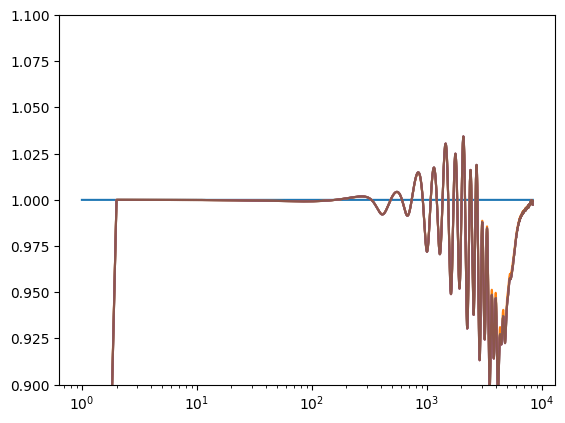

In [12]:
for i, d in enumerate(delcls_true):
    if i == 0:
        tt0 = d["tt"]
    tt = d["tt"]
    plt.plot(tt/tt0)
plt.ylim(0.9, 1.1)
plt.xscale("log")

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_4936/2300178275.py:6: RuntimeWarning: divide by zero encountered in reciprocal
  p = plt.plot(R**-1./R0**-1., label = i)
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_4936/2300178275.py:6: RuntimeWarning: invalid value encountered in divide
  p = plt.plot(R**-1./R0**-1., label = i)
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_4936/2300178275.py:7: RuntimeWarning: invalid value encountered in divide
  plt.plot(N/N0, ls = '--', alpha = 0.4, color = p[0].get_color())


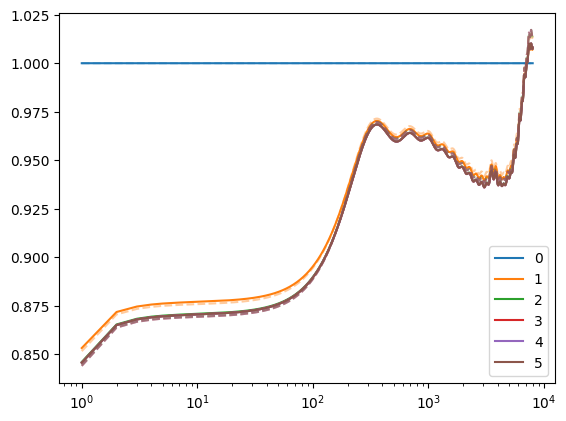

In [18]:
for i, R in enumerate(R_s):
    N = N0s_unbiased[i]
    if i == 0:
        R0 = R
        N0 = N
    p = plt.plot(R**-1./R0**-1., label = i)
    plt.plot(N/N0, ls = '--', alpha = 0.4, color = p[0].get_color())

#plt.ylim(0.9, 1.1)
plt.xscale("log")
plt.legend()

In [20]:
np.save(f"Rs_{qe_key}.npy", R_s)

In [284]:
import temperatureinfo as ti
from plancklens import qresp

r_ggs = {}

noise, beam = 1, 1

lmin, lmax = 10, 4000
ls = np.arange(0, len(delcls_true[0]["tt"]))
mask = (ls > lmin) & (ls < lmax)

noise_component = ti.get_noise(ls, noise, beam)

for i in range(itermax+1):

    ctt = delcls_true[i]["tt"]
    tot = ctt + noise_component
    fal = {"tt": np.nan_to_num(1/tot)}

    cls_f = {"tt": ctt}

    cls_w = {"tt": cls_grad[i]["tt"]}

    qe_key = "ptt"
    lmax_ivf = 4499
    r_gg_true = qresp.get_response(qe_key, lmax, 'p', cls_w, cls_f, fal, lmax_qlm = lmax_ivf)[0]
    r_ggs[i] = r_gg_true

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_31610/1058696932.py:3: RuntimeWarning: divide by zero encountered in reciprocal
  plt.plot(R**-1/Rs[0]**-1., label = f"iter {i}")
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_31610/1058696932.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(R**-1/Rs[0]**-1., label = f"iter {i}")


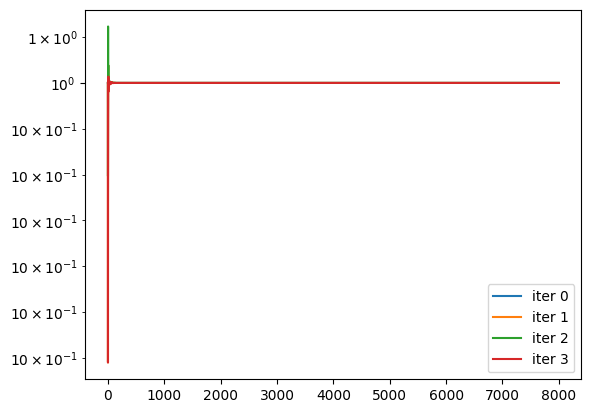

In [297]:
Rs = np.load("Rs_p_p.npy", allow_pickle=True)
for i, R in enumerate(Rs):
    plt.plot(R**-1/Rs[0]**-1., label = f"iter {i}")


plt.yscale("linear")
plt.legend()

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_31610/2917188895.py:1: RuntimeWarning: divide by zero encountered in reciprocal
  Ntot_qe = r_ggs[0]**-1.
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_31610/2917188895.py:3: RuntimeWarning: divide by zero encountered in reciprocal
  Ntot = r_ggs[i]**-1.
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_31610/2917188895.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(Ntot/Ntot_qe, label = i)


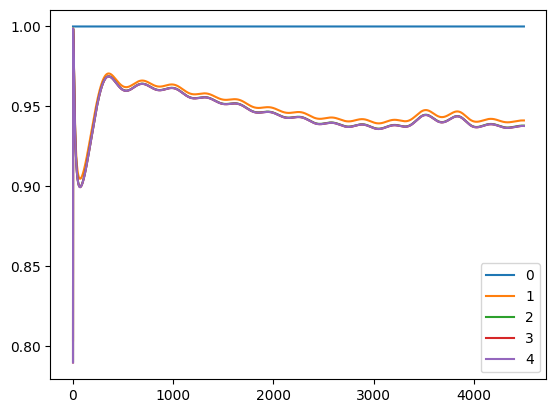

In [285]:
Ntot_qe = r_ggs[0]**-1.
for i in range(5):
    Ntot = r_ggs[i]**-1.
    plt.plot(Ntot/Ntot_qe, label = i)
plt.legend()

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_31610/1597797174.py:7: RuntimeWarning: invalid value encountered in divide
  p = plt.plot(Ntot/Ntot_qe, label = i)
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_31610/1597797174.py:8: RuntimeWarning: divide by zero encountered in reciprocal
  plt.plot(r_ggs[i]**-1./r_ggs[0]**-1., ls = "--", color = p[0].get_color())
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_31610/1597797174.py:8: RuntimeWarning: invalid value encountered in divide
  plt.plot(r_ggs[i]**-1./r_ggs[0]**-1., ls = "--", color = p[0].get_color())


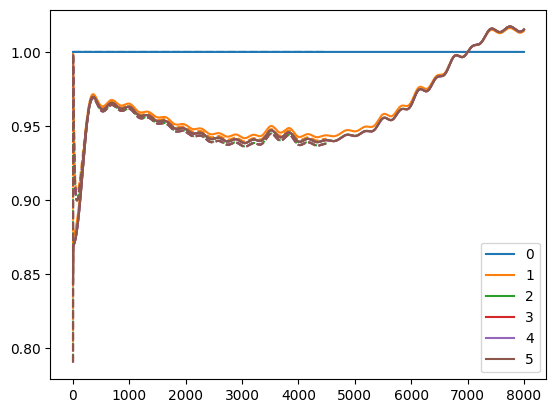

In [286]:
N0_qe = N0s_unbiased[0]
N1_qe = N1s_unbiased[0]
Ntot_qe = N0_qe + N1_qe
for i, N0 in enumerate(N0s_unbiased):
    N1 = N1s_unbiased[i]
    Ntot = N0 + N1
    p = plt.plot(Ntot/Ntot_qe, label = i)
    plt.plot(r_ggs[i]**-1./r_ggs[0]**-1., ls = "--", color = p[0].get_color())
plt.legend()

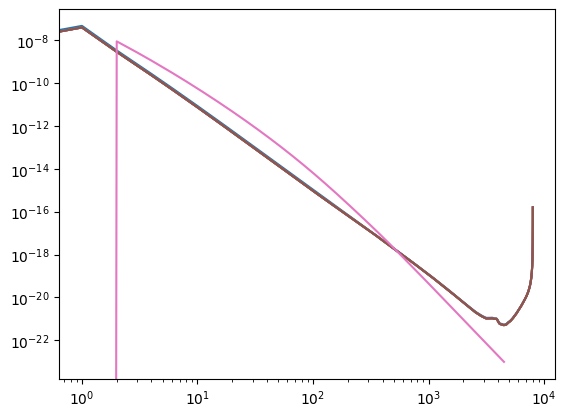

In [254]:
for N in N0s_unbiased:
    plt.plot(N)
plt.plot(pp)
plt.xscale("log")
plt.yscale("log")

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_31610/1459592056.py:6: RuntimeWarning: invalid value encountered in divide
  Wanalytical0 = pporiginal/(pporiginal + N0original + N1s_unbiased)


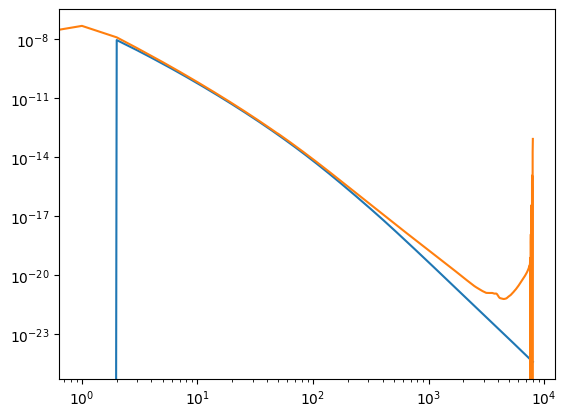

In [169]:
lmaxx = 8000
pporiginal = delcls_fid[0]["pp"][:lmaxx]
N0original = N0s_unbiased[0][:lmaxx]
N1s_unbiased = N1s_biased[0][:lmaxx]
pptotal = pporiginal + N0original + N1s_unbiased
Wanalytical0 = pporiginal/(pporiginal + N0original + N1s_unbiased)
plt.loglog(pporiginal)
plt.plot(pptotal)

In [221]:
from scipy import integrate, interpolate
def getR(cl, lmax = None):
    ls = np.arange(len(cl))
    clinterp = interpolate.interp1d(ls, np.nan_to_num(cl))
    lmax = len(cl) if lmax is None else lmax
    def integrand(l):
        return clinterp(l)/l*l**4
    integral = integrate.quad(integrand, 0, lmax)[0]*(1/4*np.pi)
    return integral

lmaxintegration = 5000
getR(pporiginal, lmaxintegration), getR(pptotal, lmaxintegration)

(2.368203680939274e-06, 3.167690690372335e-06)

In [233]:
import copy

import temperatureinfo as tinfo

cls_unl_copy = copy.deepcopy(cls_unl)
ls = np.arange(len(cls_unl["pp"]))
noise = tinfo.get_noise(ls, 1., 1.)

#cls_unl_copy["tt"] = noise

In [234]:
clscamb, cldd = cls2dls(cls_unl_copy, lmax = lmaxintegration)
ells = np.arange(len(pporiginal))
factor = (ells*(ells+1))**2/(2*np.pi)
out = camb.correlations.lensed_cls(clscamb, pptotal*factor, lmax = lmaxintegration) 
out = dls2cls(out)

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_31610/3893369768.py:3: RuntimeWarning: divide by zero encountered in power
  eps = np.exp(ll**-4.)
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_31610/3893369768.py:4: RuntimeWarning: invalid value encountered in multiply
  plt.plot(cls_unl["tt"]*(1+eps))


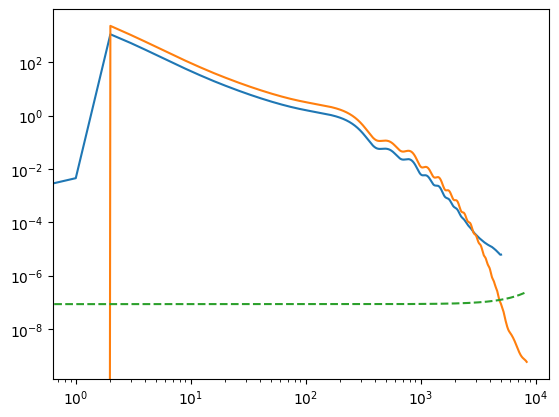

In [249]:
plt.loglog(out["tt"])
ll = np.arange(len(cls_unl["tt"]))
eps = np.exp(ll**-4.)
plt.plot(cls_unl["tt"]*(1+eps))
plt.loglog(noise, ls = '--')

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_31610/2046407830.py:4: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 5000)


(1e-08, 4738.221427467366)

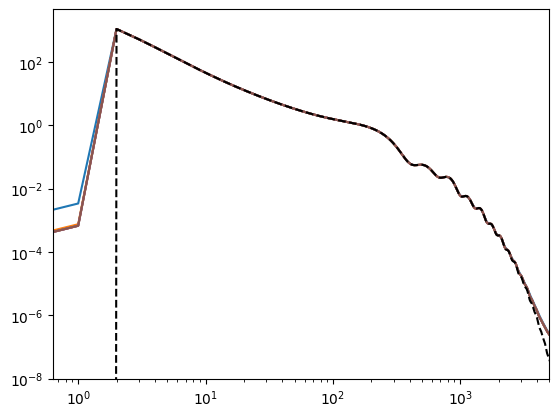

In [10]:
for d in delcls_true:
    plt.loglog(d["tt"])
plt.loglog(cls_unl["tt"], color = "black", ls = '--')
plt.xlim(0, 5000)
plt.ylim(1e-8)

In [12]:
delcls_fid[0].keys()

dict_keys(['tt', 'ee', 'bb', 'te', 'pp'])

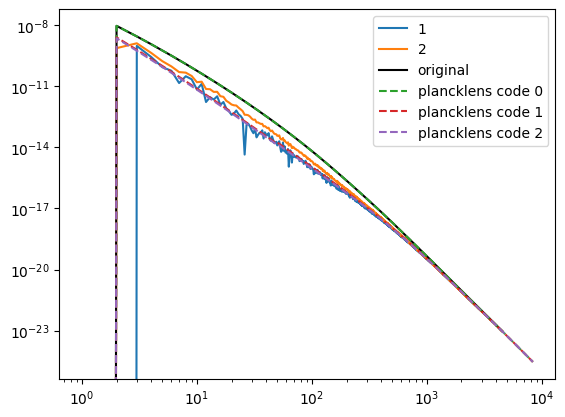

In [44]:


pp1 = pp*(1-Ws0)
pp2 = pp*(1-Ws1)


plt.loglog(pp1, label = '1')
plt.loglog(pp2, label = '2')
plt.loglog(pp, color = "black", label = 'original')

for i in range(3):
    plt.loglog(delcls_fid[i]["pp"], label = f'plancklens code {i}', ls = '--')

plt.legend()




In [14]:
ells = np.arange(len(N0s_biased[0]))

In [15]:
N1s_biased[1]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       2.85144946e-14, 2.94430035e-14, 3.03848174e-14])

In [16]:
#plt.loglog(ells, N0s_biased[0]*ells, label = "base N0")
#plt.plot(ells, abs(N1s_biased[1])*ells, label = "base N1")
#plt.xscale("log")

In [24]:
def getW(pp, noise, lmax_qlm):
    lmax = len(pp)
    W = np.zeros(lmax)
    W[:lmax_qlm] = pp[:lmax_qlm] * utils.cli(pp[:lmax_qlm] + noise[:lmax_qlm])
    return W


In [18]:
pp0 = delcls_fid[0]['pp']

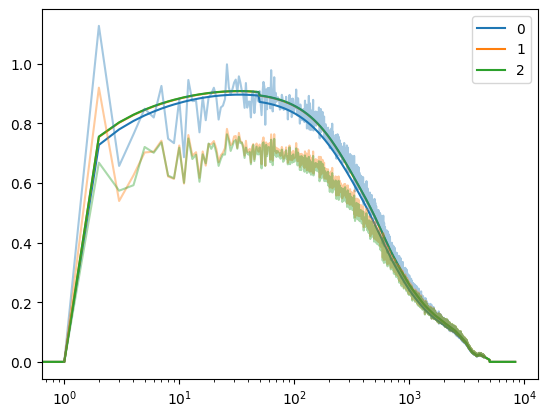

In [37]:
for i in range(3):
    W = getW(pp0, N0s_biased[i]+N1s_biased[i], lmax_qlm)
    np.savetxt(f"W_{qe_key}_"+str(i)+".txt", W)
    plt.plot(W, label = i)

plt.plot(Ws0, color = "C0", alpha = 0.4)
plt.plot(Ws1, color = "C1", alpha = 0.4)
plt.plot(Ws2, color = "C2", alpha = 0.4)

plt.legend()
plt.xscale('log')
#plt.yscale('log')

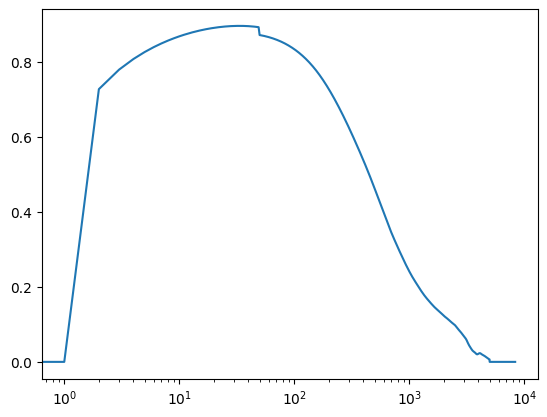

In [33]:
plt.plot(Ws0, color = "C0")
plt.xscale('log')


In [20]:
#delensed = n01.get_delcls(qe_key, itermax, cls_unl, cls_unl, fidcls_noise, fidcls_noise, lmin_ivf, lmax_ivf, lmax_qlm, version = "wN1")

Adding n1 in iterations
 [00:01:03]  ---------> 90%


In [43]:
#delcls = delensed[0]

#for i, d in enumerate(delcls):
#    if i == 0:
#        base = d["ee"]
#    plt.plot(d["ee"]/base)

In [20]:
#Use flat sky, get gradient spectra
#pars =camb.set_params(H0=None, cosmomc_theta =0.010411,lmax=4200, lens_potential_accuracy=1)
lmax = 8000
pars = camb.CAMBparams()
#print pars.Recomb.RECFAST_fudge

pars.set_cosmology(H0=67, ombh2=0.022445, omch2=0.1212, mnu=0)
pars.InitPower.set_params(As=2.1265e-09, ns=0.96)

# reionization and recombination 
pars.Reion.use_optical_depth = True
pars.Reion.optical_depth = 0.0925
pars.Reion.delta_redshift = 0.5
pars.Recomb.RECFAST_fudge = 1.14

# accuracy
pars.set_for_lmax(lmax+200, lens_potential_accuracy=4)

#non linearity
pars.NonLinear = model.NonLinear_both
pars.NonLinearModel.halofit_version = 'takahashi'
pars.Accuracy.AccurateBB = True #need this to avoid small-scale ringing
#config.lensing_method=lensing_method_curv_corr
#%time data1=camb.get_results(pars)
config.lensing_method=lensing_method_flat_corr # default

pars.max_l = 4500

%time data=camb.get_results(pars)


CPU times: user 5.84 s, sys: 71.2 ms, total: 5.91 s
Wall time: 1.14 s


In [21]:
basecamb = data.get_lensed_gradient_cls(CMB_unit = 'muK', raw_cl = True)

In [38]:
index = 0
comb = "tt"

In [132]:
pps = [pp, pp1, pp2]

ppsanalytical = [delcls_fid[i]["pp"] for i in range(3)]

In [187]:
from plancklens import qresp, nhl, utils

def cls2dls(cls, lmax = 0):
    """Turns cls dict. into camb cl array format"""
    keys = ['tt', 'ee', 'bb', 'te']
    lmax = np.max([len(cl) for cl in cls.values()]) - 1 if lmax == 0 else lmax
    dls = np.zeros((lmax + 1, 4), dtype=float)
    refac = np.arange(lmax + 1) * np.arange(1, lmax + 2, dtype=float) / (2. * np.pi)
    for i, k in enumerate(keys):
        cl = cls.get(k, np.zeros(lmax + 1, dtype=float))
        sli = slice(0, min(len(cl), lmax + 1))
        dls[sli, i] = cl[sli] * refac[sli]
    cldd = np.copy(cls.get('pp', None))
    if cldd is not None:
        cldd *= np.arange(len(cldd)) ** 2 * np.arange(1, len(cldd) + 1, dtype=float) ** 2 /  (2. * np.pi)
    return dls, cldd



def dls2cls(dls):
    """Inverse operation to cls2dls"""
    assert dls.shape[1] == 4
    lmax = dls.shape[0] - 1
    cls = {}
    refac = 2. * np.pi * utils.cli( np.arange(lmax + 1) * np.arange(1, lmax + 2, dtype=float))
    for i, k in enumerate(['tt', 'ee', 'bb', 'te']):
        cls[k] = dls[:, i] * refac
    return cls

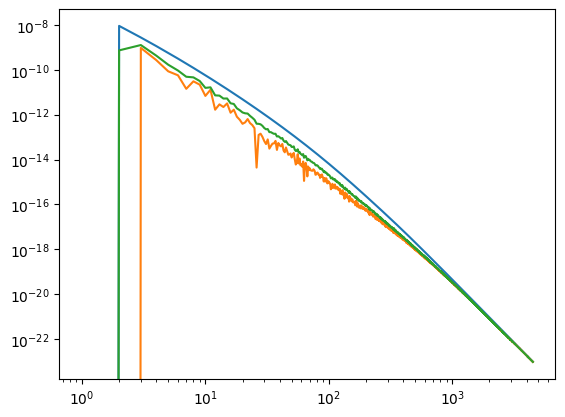

In [46]:
for p in pps:
    plt.loglog(p)

In [55]:
pps = [delcls_fid[i]["pp"] for i in range(3)]

(1e-08, 3653.4203210756546)

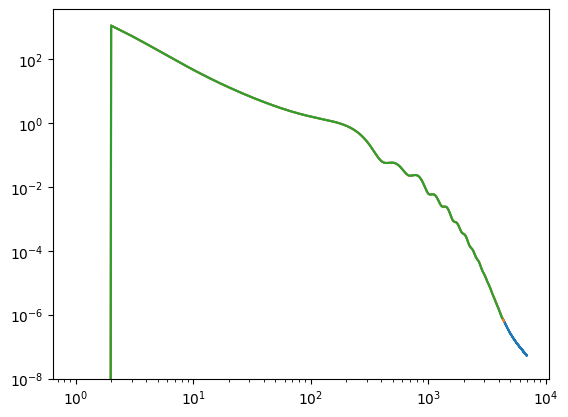

In [103]:
ells = np.arange(len(delcls_fid[0]["pp"]))
factor = (ells*(ells+1))**2/(2*np.pi)
out = data.get_lensed_cls_with_spectrum(cls_unl["pp"]*factor, raw_cl = True, CMB_unit = 'muK')
plt.plot(cls_len["tt"])
plt.loglog(out[:, 0])
plt.plot(data.get_cmb_power_spectra(raw_cl = True, CMB_unit="muK")["total"][:, 0])
plt.ylim(1e-8)

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_31610/3057562797.py:10: RuntimeWarning: divide by zero encountered in divide
  plt.plot(ttpartial/ttpartial01)
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_31610/3057562797.py:10: RuntimeWarning: invalid value encountered in divide
  plt.plot(ttpartial/ttpartial01)


(0.95, 1.02)

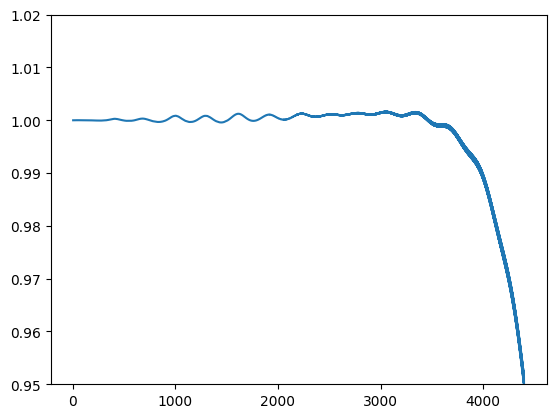

In [110]:
clscamb, cldd = cls2dls(cls_unl, lmax = 4500)
ells = np.arange(len(delcls_fid[0]["pp"]))
factor = (ells*(ells+1))**2/(2*np.pi)
out = data.get_lensed_cls_with_spectrum(delcls_fid[0]["pp"]*factor, raw_cl = False, CMB_unit = 'muK')
out = dls2cls(out)
ttpartial = out["tt"]
lpartial = np.arange(len(ttpartial))
from scipy.interpolate import interp1d
ttpartial01 = interp1d(np.arange(len(cls_len["tt"])), cls_len["tt"], kind = "linear")(lpartial)
plt.plot(ttpartial/ttpartial01)
plt.ylim(0.95, 1.02)

In [147]:
len(pp_)

4501

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_31610/1780384335.py:17: RuntimeWarning: divide by zero encountered in divide
  plt.plot(lpartial, ttpartial/ttpartial01, label = i)
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_31610/1780384335.py:17: RuntimeWarning: invalid value encountered in divide
  plt.plot(lpartial, ttpartial/ttpartial01, label = i)


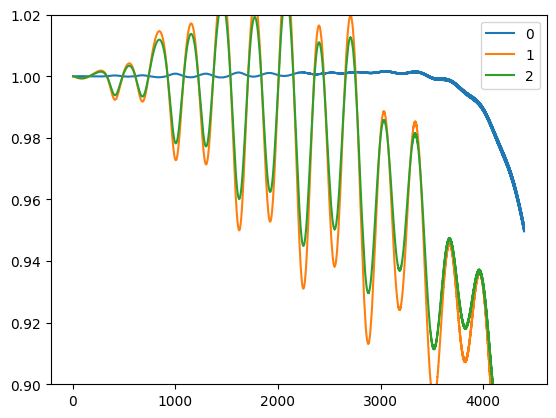

In [141]:
clscamb, cldd = cls2dls(cls_unl, lmax = len(pps[0])-1)
clslensed = []
for i, pp_ in enumerate(pps):
    ells = np.arange(len(pp_))
    factor = (ells*(ells+1))**2/(2*np.pi)
    
    out = data.get_lensed_cls_with_spectrum(pp_*factor, raw_cl = False, CMB_unit = 'muK', lmax = len(pp_)-1)
    out = dls2cls(out)
    ttpartial = out["tt"]
    lpartial = np.arange(len(ttpartial))
    clslensed += [ttpartial]
    if i == 0:
        lpartial0 = lpartial
        ttpartial0 = ttpartial
        ttpartial01 = interp1d(np.arange(len(cls_len["tt"])), cls_len["tt"], kind = "linear")(lpartial)

    plt.plot(lpartial, ttpartial/ttpartial01, label = i)
    #plt.loglog(lpartial, ttpartial/ttpartial01, label = i, alpha = 0.4)
plt.ylim(0.90, 1.02)

plt.legend()

In [142]:
for i, tt_ in enumerate(clslensed):
    np.savetxt(f"tt_partial_"+str(i)+".txt", np.c_[np.arange(len(tt_)), tt_])


In [134]:
Nmax = len(pps[0])

In [135]:
casi = {}
casi_analytical = {}

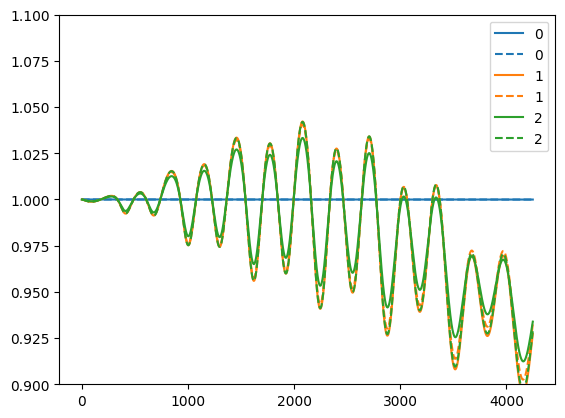

In [136]:
for i, couple in enumerate(zip(pps, ppsanalytical)):
    clpp, clppanalytical = couple
    clppanalytical = clppanalytical[:Nmax]
    ls = np.arange(0, len(clpp))
    lsanalytical = np.arange(0, len(clppanalytical))

    #clpp = d["pp"]*(ls*(ls+1))**2./2/np.pi
    clpp = clpp*(ls*(ls+1))**2./2/np.pi
    clppanalytical = clppanalytical*(ls*(ls+1))**2./2/np.pi

    caso = data.get_lensed_gradient_cls(CMB_unit = 'muK', raw_cl = True, clpp = clpp)
    casi[i] = caso

    casi_analytical[i] = data.get_lensed_gradient_cls(CMB_unit = 'muK', raw_cl = True, clpp = clppanalytical)

    p = plt.plot(caso[2:, index]/basecamb[2:, index], label = i)
    plt.plot(casi_analytical[i][2:, index]/basecamb[2:, index], label = i, ls = '--', color = p[0].get_color())

#plt.plot(basecamb[2:,0], label = "basecamb")
plt.ylim(0.9, 1.1)
plt.legend()

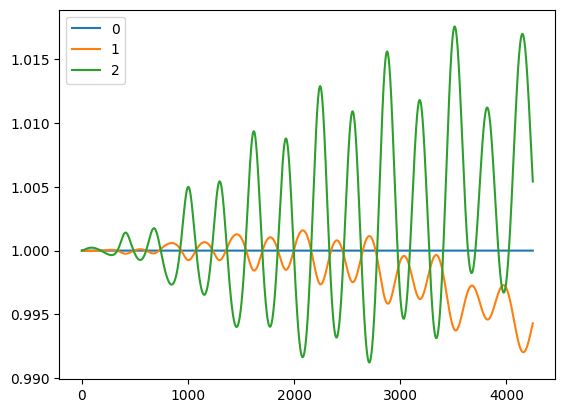

In [137]:
for i in range(3):
    plt.plot(casi[i][2:, index]/casi_analytical[i][2:, index], label = i)
plt.legend()

In [138]:
np.save(f"casi_{comb}_empirical.npy", casi)